Load packages and functions

In [1]:
import torch
import tiktoken
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import transformers
import tensorflow as tf
from models_1 import GPTModel
from helper_function import *
from load_gpt2 import *
from Lora_helper import *
from train import *

2024-07-07 00:08:05.456043: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-07 00:08:05.527942: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 00:08:07.552123: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


set up the cuda device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print cuda name
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Iterate over the available GPUs and print their names
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("CUDA is not available.")

Number of available GPUs: 4
GPU 0: Tesla V100-SXM2-32GB
GPU 1: Tesla V100-SXM2-32GB
GPU 2: Tesla V100-SXM2-32GB
GPU 3: Tesla V100-SXM2-32GB


## Data

In [3]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


We set the context window to 55 according to EDA, which would be good for most cases.

We define the training, validation, and testing using stratified sampling, ensuring that the data is balanced.

In [4]:
window_size = 55

train_dataset = RatingDataset(
    csv_file="data/train_df.csv",
    max_length=window_size,
    tokenizer=tokenizer
)
val_dataset = RatingDataset(
    csv_file="data/val_df.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
print(train_dataset.max_length)

55


We define the dataloader here.

In [5]:
from torch.utils.data import DataLoader

num_workers = 4
batch_size = 32

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

We print a sample from train loader. There are 32 mini-batches in one batch and each has length of 300 for text and 1 for target. We use padding when the length of input is shorter than 300.

In [10]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    print('text')
    print(token_ids_to_text(input_batch[0], tokenizer))
    print('label')
    print(target_batch[0])
    break

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
text
Crackdown 3 Destruction Restricted to Multiplayer: Crackdown 3 impressed earlier this week with a demonstratio... http://t.co/N08qluornx<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
label
tensor(0)
Input batch dimensions: torch.Size([32, 55])
Label batch dimensions torch.Size([32])


## Model

#### Load GPT2 pretrained model

The model we chose was the smaller variation of GPT2 which has 124M parameters. This is becasue our computation resource is constrained. We want to experiment with different training method and different model variation, rather than achieving high benchmarks.

In [8]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.2,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [9]:
model = GPTModel(BASE_CONFIG)

In [22]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [37]:
# try the pretrained model and make sure it is loaded correctly 
text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


### Modify the architecture of the base model

#### LoRA

We first need to define the out head with number of class.

In [9]:
torch.manual_seed(123)
num_classes = 5
model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)

Before applying LoRA, we first freeze all parameters in the model. We can see after we have freezed the model, there was 0 trainable parameter.

In [10]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")
 
for param in model.parameters():
    param.requires_grad = False
 
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,443,653
Total trainable parameters after: 0


Then we can apply LoRA to the model. Note Rank is a hyper parameter which is the inner dimmension of matrix A and matrix B. Alpha is the scaling factor or strengh of LoRA. It is the degree to which the output from the adapted layer can impact the original layer's output.

In [11]:
replace_linear_with_lora(model, rank=16, alpha=16)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,576


As we can see, the number of trainable parameters decreases drastically due to low rank representation of the original model.

#### Finetune with all layers

In [12]:
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

#### Finetune with some layers

In [23]:
for param in model.parameters():
    param.requires_grad = False

In [24]:
num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [25]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.trf_blocks[-2].parameters():
    param.requires_grad = True

#for param in model.trf_blocks[-3].parameters():
    #param.requires_grad = True
    
for param in model.final_norm.parameters():
    param.requires_grad = True

## Training

### LoRA Training

We first evaluate the model without training

In [19]:
torch.manual_seed(42) # For reproducibility due to the shuffling in the training data loader

model = torch.nn.DataParallel(model)
model.to(device)

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=50)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=50)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=50)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 19.50%
Validation accuracy: 19.25%
Test accuracy: 19.81%


As we can see here, the accuracy is similar to random guess. Accuracy across all loaders is similar because we use stratified sampling. Now we can train models here with imported functions.

In [14]:
# epoch 1
import time
from train import *
start_time = time.time()

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

num_epochs = 1
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.362, Val loss 3.410
Ep 1 (Step 000050): Train loss 1.629, Val loss 1.630
Ep 1 (Step 000100): Train loss 1.582, Val loss 1.601
Ep 1 (Step 000150): Train loss 1.576, Val loss 1.615
Ep 1 (Step 000200): Train loss 1.599, Val loss 1.621
Ep 1 (Step 000250): Train loss 1.165, Val loss 1.165
Ep 1 (Step 000300): Train loss 1.056, Val loss 1.163
Ep 1 (Step 000350): Train loss 1.037, Val loss 0.996
Ep 1 (Step 000400): Train loss 1.017, Val loss 0.926
Ep 1 (Step 000450): Train loss 0.995, Val loss 0.901
Ep 1 (Step 000500): Train loss 0.866, Val loss 0.921
Ep 1 (Step 000550): Train loss 1.038, Val loss 1.039
Ep 1 (Step 000600): Train loss 0.907, Val loss 0.886
Ep 1 (Step 000650): Train loss 0.869, Val loss 0.878
Ep 1 (Step 000700): Train loss 0.994, Val loss 0.944
Ep 1 (Step 000750): Train loss 0.988, Val loss 0.904
Ep 1 (Step 000800): Train loss 0.889, Val loss 0.870
Ep 1 (Step 000850): Train loss 0.863, Val loss 0.865
Ep 1 (Step 000900): Train loss 0.861, Val loss

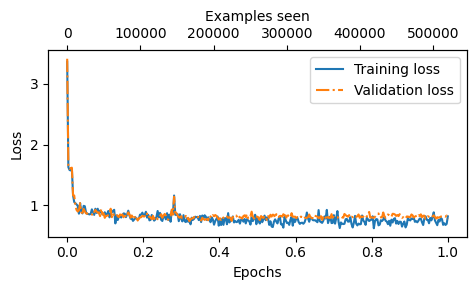

In [15]:
# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

As we can see here, the loss is very high at the begaining. But as we train more steps, the loss for validation and training decreased. At the end of the first epoch, our accuracy is much higher than the un-trained model.

In [13]:
model.to(device)
accuracy_confusion_matrix(model, device, test_loader)

Accuracy: 0.67
Confusion Matrix:
[[7980 1812  127   27   54]
 [1998 6421 1402  113   66]
 [ 284 2076 5867 1507  266]
 [  82  183 1647 5440 2648]
 [  99   45  201 1859 7796]]


array([[7980, 1812,  127,   27,   54],
       [1998, 6421, 1402,  113,   66],
       [ 284, 2076, 5867, 1507,  266],
       [  82,  183, 1647, 5440, 2648],
       [  99,   45,  201, 1859, 7796]])

### Training with all layer

In [13]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 124,441,346


Here we have all parameters trainable which means it would take a lot longer to finetune our model

In [14]:
# initial optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

Ep 1 (Step 000000): Train loss 0.318, Val loss 0.843
Ep 1 (Step 000025): Train loss 0.518, Val loss 0.874
Ep 1 (Step 000050): Train loss 0.360, Val loss 0.804
Ep 1 (Step 000075): Train loss 0.489, Val loss 0.912
Ep 1 (Step 000100): Train loss 0.290, Val loss 0.824
Ep 1 (Step 000125): Train loss 0.344, Val loss 0.743
Ep 1 (Step 000150): Train loss 0.261, Val loss 0.784
Ep 1 (Step 000175): Train loss 0.319, Val loss 0.653
Training accuracy: 90.00% | Validation accuracy: 65.62%
Ep 2 (Step 000200): Train loss 0.308, Val loss 0.729
Ep 2 (Step 000225): Train loss 0.278, Val loss 0.789
Ep 2 (Step 000250): Train loss 0.256, Val loss 0.971
Ep 2 (Step 000275): Train loss 0.197, Val loss 0.808
Ep 2 (Step 000300): Train loss 0.241, Val loss 0.785
Ep 2 (Step 000325): Train loss 0.241, Val loss 0.957
Ep 2 (Step 000350): Train loss 0.274, Val loss 0.758
Ep 2 (Step 000375): Train loss 0.175, Val loss 0.807
Training accuracy: 91.88% | Validation accuracy: 66.88%
Ep 3 (Step 000400): Train loss 0.579, Va

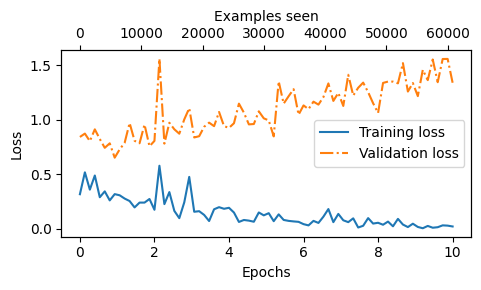

In [16]:
import time
from train import *
start_time = time.time()


num_epochs = 10
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=25, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")
# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Here the model performed similarly compared to using LoRA. But it takes less time which is unexpected

In [12]:
model.to(device)
accuracy_confusion_matrix(model, device, test_loader)

Accuracy: 0.68
Confusion Matrix:
[[8108 1717  102   20   53]
 [2015 6405 1454   89   37]
 [ 240 1965 5910 1704  181]
 [  49  132 1379 6152 2288]
 [  64   36  136 2163 7601]]


array([[8108, 1717,  102,   20,   53],
       [2015, 6405, 1454,   89,   37],
       [ 240, 1965, 5910, 1704,  181],
       [  49,  132, 1379, 6152, 2288],
       [  64,   36,  136, 2163, 7601]])

### Training with some layers

In [26]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params:,}")

Total trainable parameters: 14,178,818


In [27]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

Ep 1 (Step 000000): Train loss 1.414, Val loss 1.306
Ep 1 (Step 000025): Train loss 0.782, Val loss 0.720
Ep 1 (Step 000050): Train loss 0.761, Val loss 0.697
Ep 1 (Step 000075): Train loss 0.708, Val loss 0.695
Ep 1 (Step 000100): Train loss 0.721, Val loss 0.706
Ep 1 (Step 000125): Train loss 0.750, Val loss 0.712
Ep 1 (Step 000150): Train loss 0.669, Val loss 0.680
Ep 1 (Step 000175): Train loss 0.700, Val loss 0.687
Training accuracy: 48.75% | Validation accuracy: 54.37%
Ep 2 (Step 000200): Train loss 0.667, Val loss 0.675
Ep 2 (Step 000225): Train loss 0.700, Val loss 0.689
Ep 2 (Step 000250): Train loss 0.705, Val loss 0.680
Ep 2 (Step 000275): Train loss 0.663, Val loss 0.660
Ep 2 (Step 000300): Train loss 0.678, Val loss 0.660
Ep 2 (Step 000325): Train loss 0.703, Val loss 0.652
Ep 2 (Step 000350): Train loss 0.618, Val loss 0.630
Ep 2 (Step 000375): Train loss 0.595, Val loss 0.584
Training accuracy: 73.75% | Validation accuracy: 73.75%
Ep 3 (Step 000400): Train loss 0.563, Va

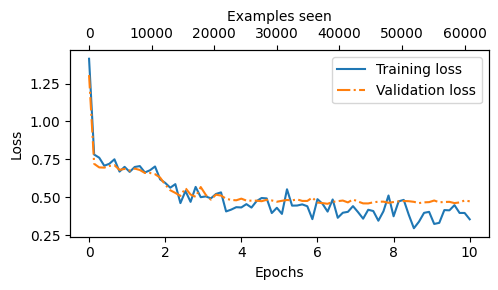

In [28]:
import time
from train import *
start_time = time.time()

num_epochs = 10
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=25, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

Ep 1 (Step 000000): Train loss 0.380, Val loss 0.434
Ep 1 (Step 000050): Train loss 0.233, Val loss 0.443
Ep 1 (Step 000100): Train loss 0.352, Val loss 0.468
Ep 1 (Step 000150): Train loss 0.264, Val loss 0.441
Training accuracy: 91.88% | Validation accuracy: 77.50%
Ep 2 (Step 000200): Train loss 0.268, Val loss 0.467
Ep 2 (Step 000250): Train loss 0.253, Val loss 0.480
Ep 2 (Step 000300): Train loss 0.219, Val loss 0.489
Ep 2 (Step 000350): Train loss 0.240, Val loss 0.507
Training accuracy: 93.75% | Validation accuracy: 78.12%
Ep 3 (Step 000400): Train loss 0.207, Val loss 0.489
Ep 3 (Step 000450): Train loss 0.270, Val loss 0.513
Ep 3 (Step 000500): Train loss 0.214, Val loss 0.556
Ep 3 (Step 000550): Train loss 0.147, Val loss 0.513
Training accuracy: 93.12% | Validation accuracy: 78.12%
Ep 4 (Step 000600): Train loss 0.177, Val loss 0.575
Ep 4 (Step 000650): Train loss 0.174, Val loss 0.589
Ep 4 (Step 000700): Train loss 0.329, Val loss 0.632
Ep 4 (Step 000750): Train loss 0.243,

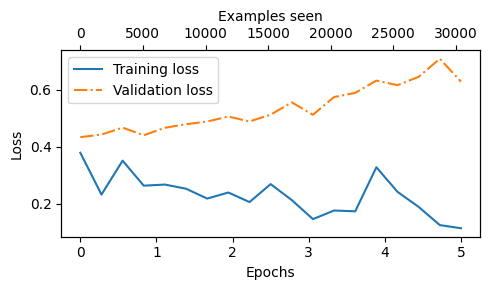

In [34]:
start_time = time.time()

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# plot
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
 
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

#### inference

In [29]:
model.to(device)
accuracy_confusion_matrix(model, device, test_loader)

Accuracy: 0.66
Confusion Matrix:
[[7728 1930  225   54   63]
 [1900 6047 1839  162   52]
 [ 228 1812 5744 1992  224]
 [  52  129 1433 5929 2457]
 [  65   43  181 2200 7511]]


array([[7728, 1930,  225,   54,   63],
       [1900, 6047, 1839,  162,   52],
       [ 228, 1812, 5744, 1992,  224],
       [  52,  129, 1433, 5929, 2457],
       [  65,   43,  181, 2200, 7511]])

## Conclusion